# BBC News Classification project 

This project looks at the Kaggle BBC News dataset and applies (and optimises) an unsupervised model to the dataset. It then compares its performance against the best of 4 supervise learning models that the dataset is applied to. 

### EDA and visualisations

In this first section I shall extract word features and show Exploratory Data Analysis (EDA) 

This includes data cleaning procedures and visualisations.

In [105]:
!pip install nltk
!pip install wordcloud


import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
import gensim
from gensim.models import Word2Vec
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [106]:
# Loading the training data and checking it comes through correctly 

data_path = '/Users/alex/Desktop/github_projects/learn-ai-bbc/BBC News Train.csv'
df = pd.read_csv(data_path)
df.head()


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [107]:
# Cleaning the data - checking for missing values, removing duplicates, text preprocessing for Word2Vec, encoding the target column, saving the cleaned data

# Missing values
df.isnull().sum()
df = df.dropna(subset=['Text', 'Category'])

# Removing duplicates
df = df.drop_duplicates(subset=['Text'])
df = df.drop_duplicates(subset=['ArticleId'])

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text preprocessing for Word2Vec
def preprocess_for_word2vec(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    return words

df['Processed_Text'] = df['Text'].apply(preprocess_for_word2vec)
df[['Text', 'Processed_Text']].head()

# Encoding the target column (Category)
le = LabelEncoder()
df['Category_encoded'] = le.fit_transform(df['Category'])
df[['Category', 'Category_encoded']].head()

# Cleaned data summary
df.info()
df.head()

# Save the cleaned and preprocessed data
df.to_csv('/Users/alex/Desktop/github_projects/cleaned_data_word2vec.csv', index=False)


[nltk_data] Downloading package stopwords to /Users/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1489
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ArticleId         1440 non-null   int64 
 1   Text              1440 non-null   object
 2   Category          1440 non-null   object
 3   Processed_Text    1440 non-null   object
 4   Category_encoded  1440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 67.5+ KB


In [108]:
# Going from raw text to feature vectors - Word2Vec

### I have chosen to use Word2Vec as the technique to create the word embeddings. 
### It captures the semantic relationships between words by seeing that similar words will have similar vectors. 
### I will train a Word2Vec model on the preprocessed text above, using gensim's model. 
### I will then convert the entire text for each article into a vector representation by averaging 
### the word vectors for all words in an article. 

sentences = df['Processed_Text'].tolist()

model = Word2Vec(
    sentences,
    vector_size=100,  
    window=5,       
    min_count=2,  
    workers=4  
)

model.save("/Users/alex/Desktop/github_projects/word2vec_bbc.model")

# Checks: 
word_vector = model.wv['site']
print(word_vector)
similar_words = model.wv.most_similar('site')
print(similar_words)


[-0.18450338  0.19854982  0.10750908  0.06199098  0.04756534 -0.5482147
  0.28590867  0.94179344 -0.20148583 -0.47928247 -0.16797964 -0.77314246
 -0.31739673  0.19886535  0.00682774 -0.3205252   0.01961185 -0.21695773
 -0.02971647 -0.9073935  -0.00789174  0.06744459  0.6392588  -0.19854176
 -0.25998244 -0.36870715 -0.37060317 -0.26000538 -0.32317325  0.18221416
  0.816796   -0.1925347   0.6633294  -0.4889052  -0.27708668  0.31377387
  0.09432319 -0.32854778 -0.17638688 -0.65168357  0.07726695 -0.1494467
 -0.5500482   0.27825922  0.40255195 -0.31810406 -0.55555934 -0.47933623
  0.27036914  0.28922313  0.15311332 -0.40351844  0.02318834 -0.24133927
 -0.09916063  0.13714166  0.5220042  -0.09856926 -0.08615497  0.27157933
 -0.05325676  0.05474565  0.37951654 -0.21167468 -0.72709185  0.26007053
 -0.01178001  0.40235204 -0.69886917  0.6443371   0.0664992   0.15914628
  1.0003853   0.15535215  0.3095548   0.07874548  0.15798147 -0.08978504
 -0.4145722  -0.02054127 -0.33363917  0.16547878 -0.3

[('the', 33913), ('to', 15998), ('of', 12560), ('and', 11924), ('a', 11756), ('in', 11365), ('s', 5874), ('for', 5611), ('is', 5336), ('that', 5072)]
count    1440.000000
mean      377.189583
std       208.654239
min        89.000000
25%       245.750000
50%       331.000000
75%       461.000000
max      3266.000000
Name: word_count, dtype: float64


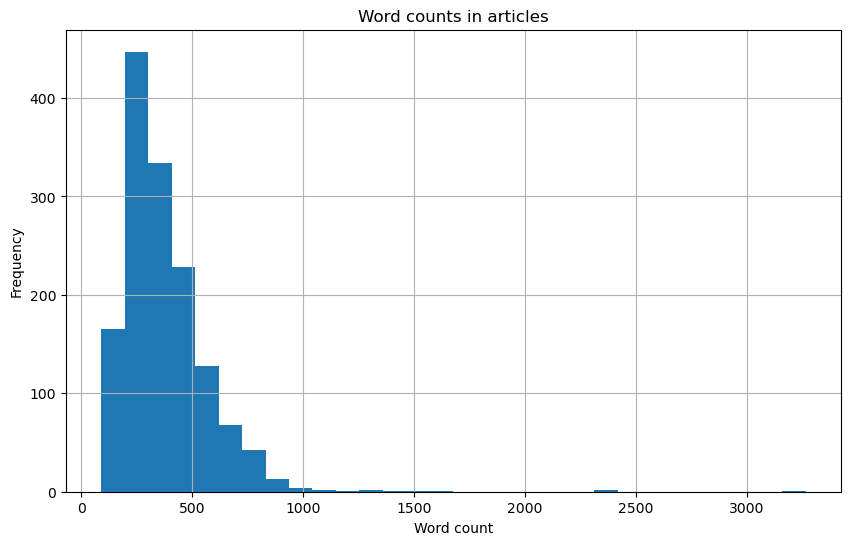

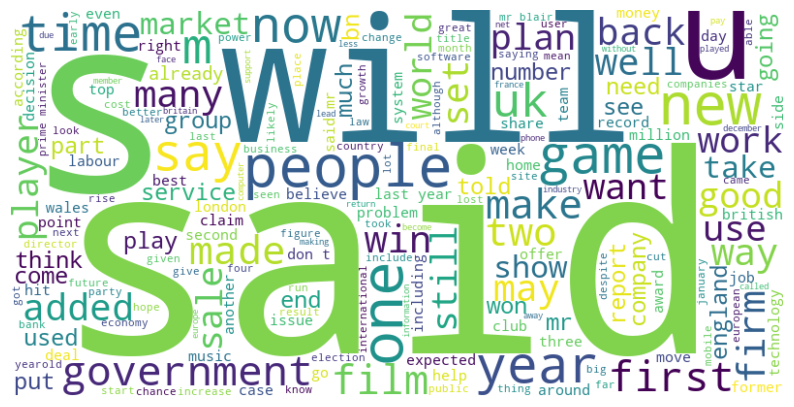

In [109]:
# EDA and visualisations

# Word frequency 
all_words = [word for tokens in df['Processed_Text'] for word in tokens]
word_freq = Counter(all_words)
print(word_freq.most_common(10))

# Word count per article
df['word_count'] = df['Processed_Text'].apply(len)
print(df['word_count'].describe())

plt.figure(figsize=(10,6))
df['word_count'].hist(bins=30)
plt.title('Word counts in articles')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.show()

# Word cloud
all_words_joined = ' '.join(all_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words_joined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#### Analysis

Main insights:

Word count distribution - most articles have between 200 and 500 words, a few outliers exceed 1,000.
"Said", "people", "time" etc and other common words are very prominent but so are domain specific words like "game" "service" and "government" so this means those categories probably have good representation in the data set.

Moving forwards, the best plan for feature engineering would be to use the word vectors generated to build models that find the relationships between the words semantically.  I can try a TF IDF approach for representing the text that could capture important words that are frequent in a category specific way.


### Model building

Taking an unsupervised approach with matrix factorisation method to discover the topics in the news articles and then using the labels to check the accuracy.

1) When you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?

No you shouldn't include the test data set because by definition it is supposed to simulate un seen data and be used only afterwards, to make predictions. 

Train accuracy: 0.9282


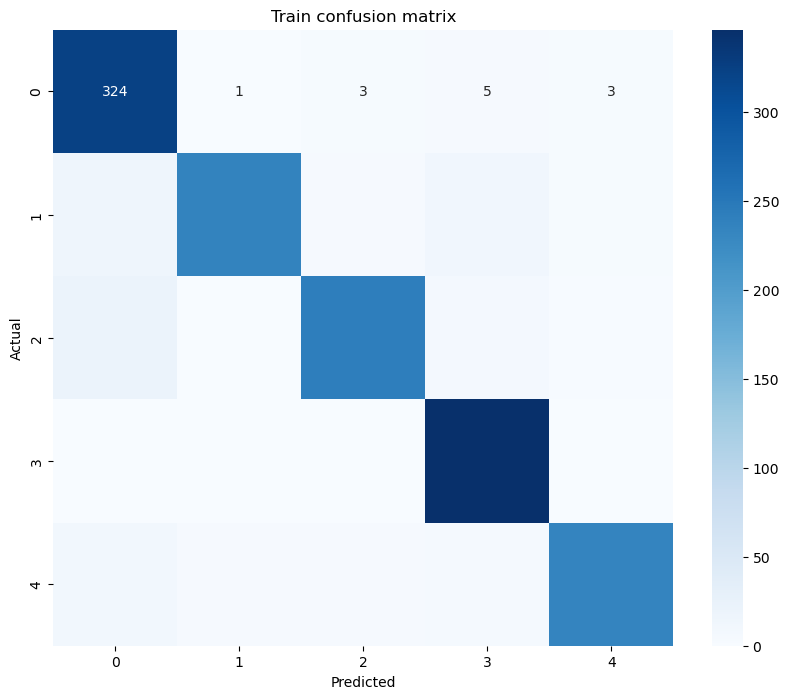

Train classification report:
               precision    recall  f1-score   support

     business       0.87      0.96      0.92       336
entertainment       0.98      0.86      0.92       273
     politics       0.95      0.89      0.92       274
        sport       0.92      1.00      0.96       346
         tech       0.96      0.90      0.93       261

     accuracy                           0.93      1490
    macro avg       0.94      0.92      0.93      1490
 weighted avg       0.93      0.93      0.93      1490


Sample of test predictions:
   ArticleId Predicted_Category
0       1018              sport
1       1319               tech
2       1138              sport
3        459           business
4       1020              sport
5         51              sport
6       2025           politics
7       1479              sport
8         27      entertainment
9        397           business

Test predictions saved to 'bbc_news_test_predictions.csv'

Distribution of predicted catego

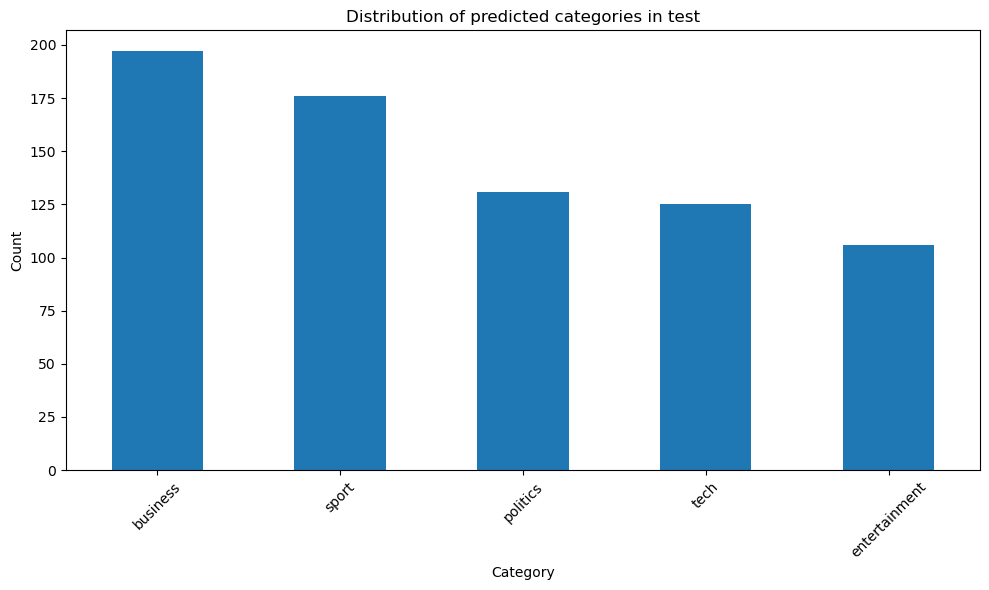

In [110]:
train_path = '/Users/alex/Desktop/github_projects/learn-ai-bbc/BBC News Train.csv'
train_df = pd.read_csv(train_path)

test_path = '/Users/alex/Desktop/github_projects/learn-ai-bbc/BBC News Test.csv'
test_df = pd.read_csv(test_path)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

# Applying preprocessing to train and test data
train_df['Cleaned_Text'] = train_df['Text'].apply(preprocess_text)
test_df['Cleaned_Text'] = test_df['Text'].apply(preprocess_text)

# Encoding categories for training data
le = LabelEncoder()
train_df['Category_encoded'] = le.fit_transform(train_df['Category'])

# Creating TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
train_tfidf = tfidf_vectorizer.fit_transform(train_df['Cleaned_Text'])
test_tfidf = tfidf_vectorizer.transform(test_df['Cleaned_Text'])

# NMF model
n_components = 20
nmf_model = NMF(n_components=n_components, random_state=42)
nmf_features_train = nmf_model.fit_transform(train_tfidf)
nmf_features_test = nmf_model.transform(test_tfidf)

# Logistic Regression on NMF features
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(nmf_features_train, train_df['Category_encoded'])
train_predictions = clf.predict(nmf_features_train)

# Stats for train data
train_accuracy = accuracy_score(train_df['Category_encoded'], train_predictions)
print(f"Train accuracy: {train_accuracy:.4f}")

train_cm = confusion_matrix(train_df['Category_encoded'], train_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Train confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Train classification report:")
print(classification_report(train_df['Category_encoded'], train_predictions, target_names=le.classes_))

# Stats on test data
test_predictions = clf.predict(nmf_features_test)

test_predictions_categories = le.inverse_transform(test_predictions)
test_df['Predicted_Category'] = test_predictions_categories

print("\nSample of test predictions:")
print(test_df[['ArticleId', 'Predicted_Category']].head(10))

# Saving test predictions to a CSV file
test_df[['ArticleId', 'Predicted_Category']].to_csv('/Users/alex/Desktop/github_projects/bbc_news_test_predictions.csv', index=False)
print("\nTest predictions saved to 'bbc_news_test_predictions.csv'")

# Print distribution of predicted categories in test data
print("\nDistribution of predicted categories in test:")
print(test_df['Predicted_Category'].value_counts(normalize=True))

# Visualize distribution of predicted categories in test data
plt.figure(figsize=(10, 6))
test_df['Predicted_Category'].value_counts().plot(kind='bar')
plt.title('Distribution of predicted categories in test')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Max Features: 1000, NMF Components: 10, Validation Accuracy: 0.9329
Max Features: 1000, NMF Components: 20, Validation Accuracy: 0.9228
Max Features: 1000, NMF Components: 30, Validation Accuracy: 0.9362
Max Features: 1000, NMF Components: 40, Validation Accuracy: 0.8926


/Users/alex/miniconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Max Features: 1000, NMF Components: 50, Validation Accuracy: 0.8691
Max Features: 3000, NMF Components: 10, Validation Accuracy: 0.9262
Max Features: 3000, NMF Components: 20, Validation Accuracy: 0.9329
Max Features: 3000, NMF Components: 30, Validation Accuracy: 0.9295
Max Features: 3000, NMF Components: 40, Validation Accuracy: 0.8893
Max Features: 3000, NMF Components: 50, Validation Accuracy: 0.8423
Max Features: 5000, NMF Components: 10, Validation Accuracy: 0.9329
Max Features: 5000, NMF Components: 20, Validation Accuracy: 0.9228
Max Features: 5000, NMF Components: 30, Validation Accuracy: 0.9262
Max Features: 5000, NMF Components: 40, Validation Accuracy: 0.9128
Max Features: 5000, NMF Components: 50, Validation Accuracy: 0.8658
Max Features: 7000, NMF Components: 10, Validation Accuracy: 0.9228
Max Features: 7000, NMF Components: 20, Validation Accuracy: 0.9329
Max Features: 7000, NMF Components: 30, Validation Accuracy: 0.9195
Max Features: 7000, NMF Components: 40, Validati

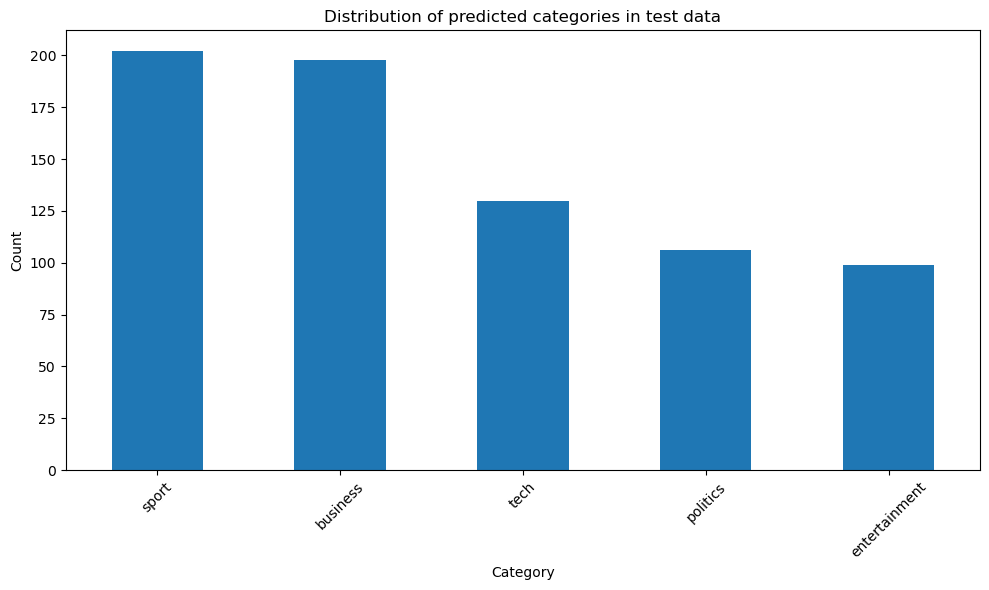

In [111]:
# Trying with different hyperparameters

train_path = '/Users/alex/Desktop/github_projects/learn-ai-bbc/BBC News Train.csv'
train_df = pd.read_csv(train_path)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

train_df['Cleaned_Text'] = train_df['Text'].apply(preprocess_text)

le = LabelEncoder()
train_df['Category_encoded'] = le.fit_transform(train_df['Category'])

X_train, X_val, y_train, y_val = train_test_split(
    train_df['Cleaned_Text'], train_df['Category_encoded'], 
    test_size=0.2, random_state=42
)

# Hyperparameter ranges for components and features
nmf_components_range = [10, 20, 30, 40, 50]
max_features_range = [1000, 3000, 5000, 7000, 10000]

results = []

# Hyperparameter tuning
for max_features in max_features_range:
    for n_components in nmf_components_range:
        tfidf_vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
        train_tfidf = tfidf_vectorizer.fit_transform(X_train)
        val_tfidf = tfidf_vectorizer.transform(X_val)

        nmf_model = NMF(n_components=n_components, random_state=42)
        nmf_features_train = nmf_model.fit_transform(train_tfidf)
        nmf_features_val = nmf_model.transform(val_tfidf)

        clf = LogisticRegression(random_state=42, max_iter=1000)
        clf.fit(nmf_features_train, y_train)

        val_predictions = clf.predict(nmf_features_val)

        val_accuracy = accuracy_score(y_val, val_predictions)

        results.append({
            'max_features': max_features,
            'n_components': n_components,
            'val_accuracy': val_accuracy
        })

        print(f"Max Features: {max_features}, NMF Components: {n_components}, Validation Accuracy: {val_accuracy:.4f}")

results_df = pd.DataFrame(results)

# Visualising

# Find best hyperparameters
best_result = max(results, key=lambda x: x['val_accuracy'])
print("\nBest hyperparameters:")
print(f"Max features: {best_result['max_features']}")
print(f"NMF components: {best_result['n_components']}")
print(f"Validation accuracy: {best_result['val_accuracy']:.4f}")

# Create summary table
summary_table = results_df.groupby(['max_features', 'n_components'])['val_accuracy'].mean().unstack()
print("\nSummary table (average validation accuracy):")
print(summary_table)

summary_table.to_csv('hyperparameter_summary.csv')
print("\nSummary table saved to 'hyperparameter_summary.csv'")

# Train final model with best hyperparameters
best_tfidf = TfidfVectorizer(max_features=best_result['max_features'], stop_words='english')
best_tfidf_train = best_tfidf.fit_transform(train_df['Cleaned_Text'])

best_nmf = NMF(n_components=best_result['n_components'], random_state=42)
best_nmf_features = best_nmf.fit_transform(best_tfidf_train)

best_clf = LogisticRegression(random_state=42, max_iter=1000)
best_clf.fit(best_nmf_features, train_df['Category_encoded'])

# Test data
test_path = '/Users/alex/Desktop/github_projects/learn-ai-bbc/BBC News Test.csv'
test_df = pd.read_csv(test_path)
test_df['Cleaned_Text'] = test_df['Text'].apply(preprocess_text)

test_tfidf = best_tfidf.transform(test_df['Cleaned_Text'])
test_nmf_features = best_nmf.transform(test_tfidf)
test_predictions = best_clf.predict(test_nmf_features)
test_predictions_categories = le.inverse_transform(test_predictions)

test_df['Predicted_Category'] = test_predictions_categories

test_df[['ArticleId', 'Predicted_Category']].to_csv('bbc_news_test_predictions_best_model.csv', index=False)
print("\nTest predictions (using best model) saved to 'bbc_news_test_predictions_best_model.csv'")

print("\nDistribution of predicted categories in test data:")
print(test_df['Predicted_Category'].value_counts(normalize=True))

plt.figure(figsize=(10, 6))
test_df['Predicted_Category'].value_counts().plot(kind='bar')
plt.title('Distribution of predicted categories in test data')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('test_predictions_distribution.png')
plt.show()


[nltk_data] Downloading package punkt to /Users/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/alex/miniconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1 reached. Increase it to improve convergence.
  warnings.warn(
/Users/alex/miniconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1 reached. Increase it to improve convergence.
  warnings.warn(
/Users/alex/miniconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1 reached. Increase it to improve convergence.
  warnings.warn(


Cross-validation scores: [0.96308725 0.94295302 0.96308725 0.97651007 0.95302013]
Mean CV score: 0.9597

Classification Report (Training Data):
               precision    recall  f1-score   support

     business       1.00      1.00      1.00       336
entertainment       1.00      1.00      1.00       273
     politics       1.00      1.00      1.00       274
        sport       1.00      1.00      1.00       346
         tech       1.00      1.00      1.00       261

     accuracy                           1.00      1490
    macro avg       1.00      1.00      1.00      1490
 weighted avg       1.00      1.00      1.00      1490



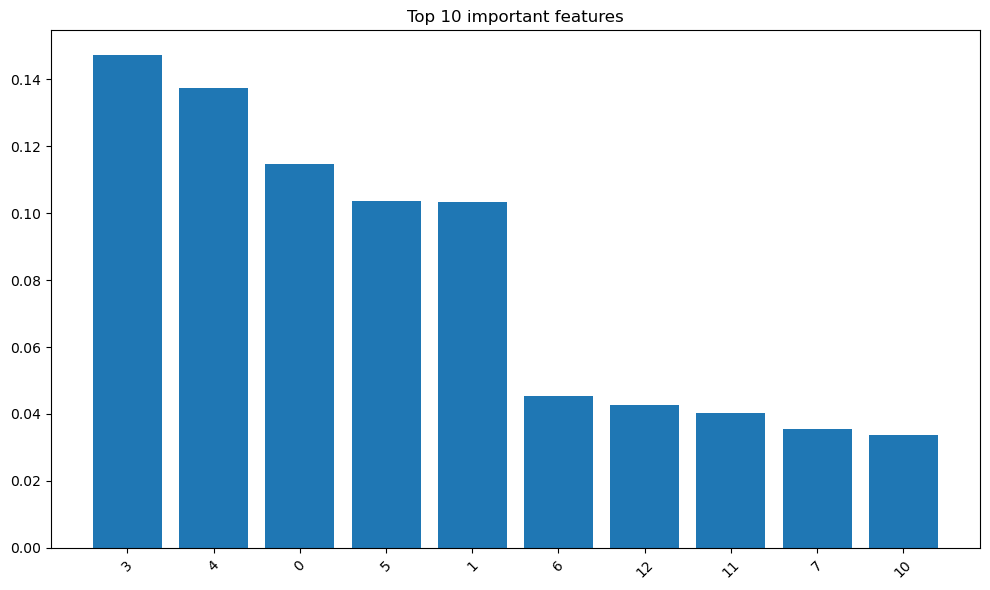


Test predictions (using improved model) saved to 'bbc_news_test_predictions_improved_model.csv'

New distribution of predicted categories in test data:
Predicted_Category
business         0.240816
sport            0.223129
tech             0.193197
politics         0.189116
entertainment    0.153741
Name: proportion, dtype: float64


/Users/alex/miniconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1 reached. Increase it to improve convergence.
  warnings.warn(


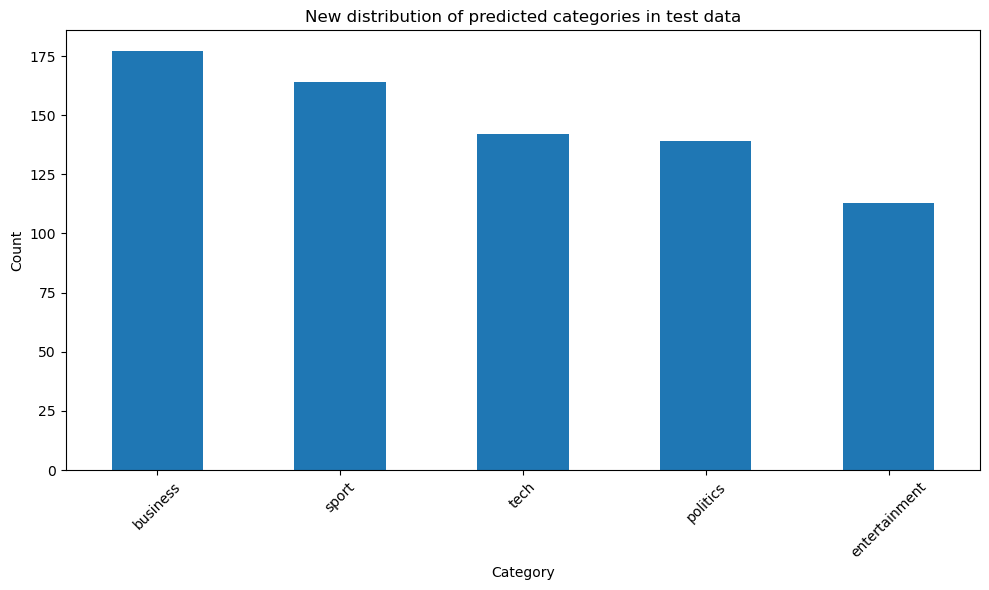

In [112]:
### Improving the model by enhancing the text prepocessing, 
### implementing feature selection to focus on the most important features, 
### trying Random Forest instead as a classification algorithm, 
### using cross validation for a better performance estimation, 
### and implementing early stopping for NMF to prevent overfitting

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

train_path = '/Users/alex/Desktop/github_projects/learn-ai-bbc/BBC News Train.csv'
train_df = pd.read_csv(train_path)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

train_df['Cleaned_Text'] = train_df['Text'].apply(preprocess_text)

le = LabelEncoder()
train_df['Category_encoded'] = le.fit_transform(train_df['Category'])

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
train_tfidf = tfidf_vectorizer.fit_transform(train_df['Cleaned_Text'])

selector = SelectKBest(chi2, k=3000)
train_tfidf_selected = selector.fit_transform(train_tfidf, train_df['Category_encoded'])

def nmf_with_early_stopping(X, n_components, max_iter=200, tol=1e-4):
    nmf = NMF(n_components=n_components, random_state=42, max_iter=1)
    prev_error = float('inf')
    for _ in range(max_iter):
        nmf.fit(X)
        error = nmf.reconstruction_err_
        if prev_error - error < tol:
            break
        prev_error = error
    return nmf

nmf_model = nmf_with_early_stopping(train_tfidf_selected, n_components=30)
nmf_features = nmf_model.transform(train_tfidf_selected)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

cv_scores = cross_val_score(rf_clf, nmf_features, train_df['Category_encoded'], cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")

rf_clf.fit(nmf_features, train_df['Category_encoded'])

train_predictions = rf_clf.predict(nmf_features)

print("\nClassification Report (Training Data):")
print(classification_report(train_df['Category_encoded'], train_predictions, target_names=le.classes_))

# Feature importance
feature_importance = rf_clf.feature_importances_
top_features = np.argsort(feature_importance)[-10:][::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 10 important features")
plt.bar(range(10), feature_importance[top_features])
plt.xticks(range(10), top_features, rotation=45)
plt.tight_layout()
plt.savefig('top_features.png')
plt.show()

# Test data
test_path = '/Users/alex/Desktop/github_projects/learn-ai-bbc/BBC News Test.csv'
test_df = pd.read_csv(test_path)
test_df['Cleaned_Text'] = test_df['Text'].apply(preprocess_text)

test_tfidf = tfidf_vectorizer.transform(test_df['Cleaned_Text'])
test_tfidf_selected = selector.transform(test_tfidf)
test_nmf_features = nmf_model.transform(test_tfidf_selected)
test_predictions = rf_clf.predict(test_nmf_features)

test_predictions_categories = le.inverse_transform(test_predictions)
test_df['Predicted_Category'] = test_predictions_categories

# Saving test predictions to a CSV file
test_df[['ArticleId', 'Predicted_Category']].to_csv('bbc_news_test_predictions_improved_model.csv', index=False)
print("\nTest predictions (using improved model) saved to 'bbc_news_test_predictions_improved_model.csv'")

# Print distribution of predicted categories in test data
print("\nNew distribution of predicted categories in test data:")
print(test_df['Predicted_Category'].value_counts(normalize=True))

# Visualize distribution of predicted categories in test data
plt.figure(figsize=(10, 6))
test_df['Predicted_Category'].value_counts().plot(kind='bar')
plt.title('New distribution of predicted categories in test data')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('test_predictions_distribution_improved.png')
plt.show()


#### Comparison with supervised learning models

I compare the performance of the unsupervised model to supervised models by considering 4 types of supervised models: logistic regression, random forest, SVM and gradient boosting. I compare their performance on both training and test data, and visualise the results.


Logistic Regression Results:
Train Accuracy: 0.9975
Validation Accuracy: 0.9597
Training Time: 0.48 seconds

Classification Report (Validation Set):
               precision    recall  f1-score   support

     business       0.95      0.97      0.96        75
entertainment       0.96      0.98      0.97        46
     politics       0.93      0.93      0.93        56
        sport       0.98      1.00      0.99        63
         tech       0.98      0.91      0.95        58

     accuracy                           0.96       298
    macro avg       0.96      0.96      0.96       298
 weighted avg       0.96      0.96      0.96       298


Random Forest Results:
Train Accuracy: 1.0000
Validation Accuracy: 0.9732
Training Time: 0.59 seconds

Classification Report (Validation Set):
               precision    recall  f1-score   support

     business       0.97      0.96      0.97        75
entertainment       0.98      0.96      0.97        46
     politics       0.95      0.98      0.

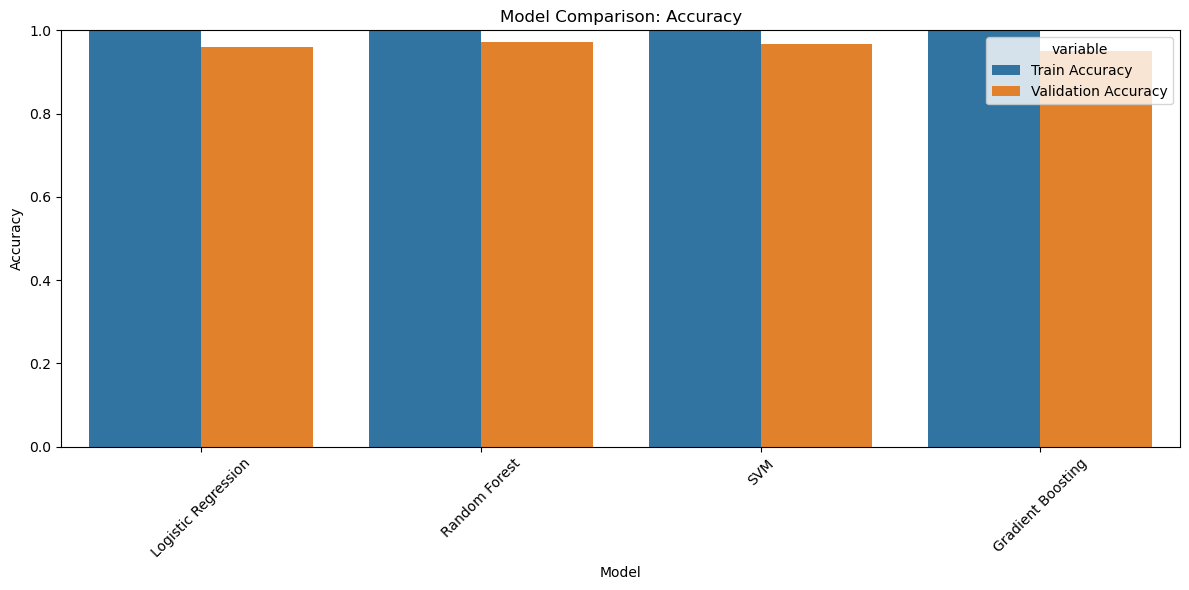

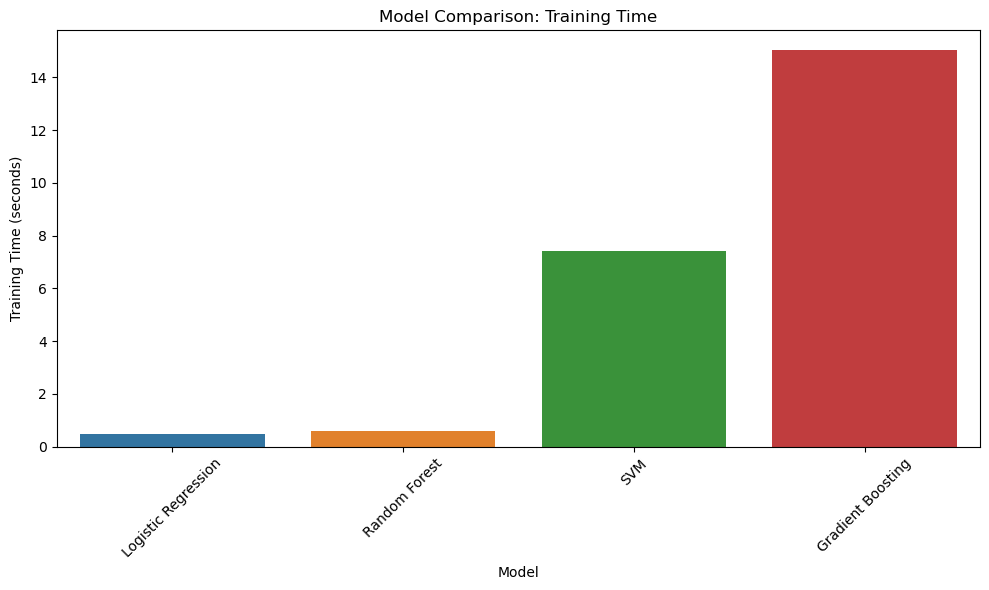


Best model: Random Forest

Test predictions (using best model) saved to 'bbc_news_test_predictions_best_model.csv'

Distribution of predicted categories in test data:
Predicted_Category
business         0.238095
sport            0.231293
politics         0.195918
tech             0.178231
entertainment    0.156463
Name: proportion, dtype: float64


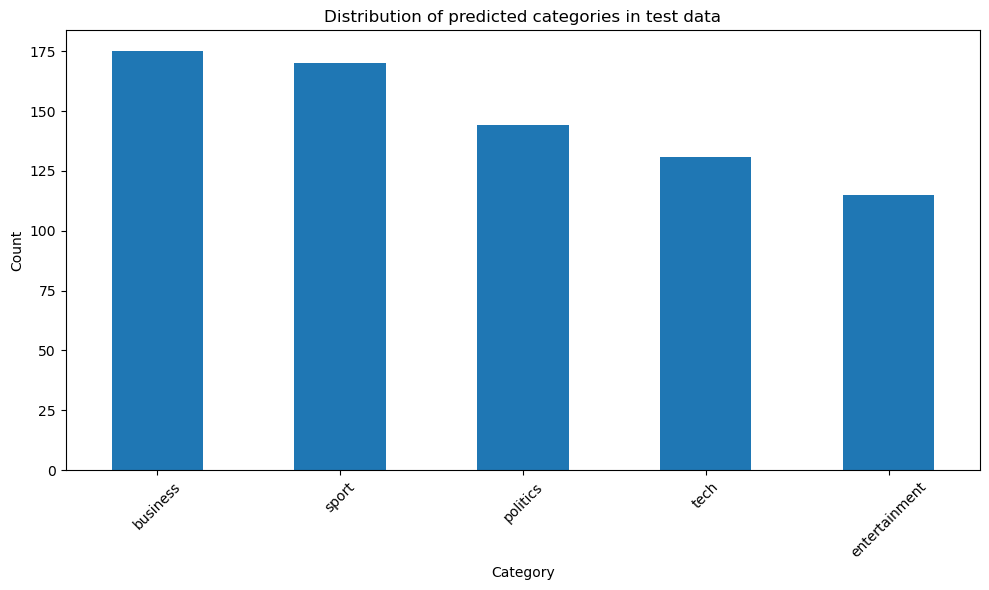


Model comparison results saved to 'model_comparison_results.csv'


In [113]:
train_path = '/Users/alex/Desktop/github_projects/learn-ai-bbc/BBC News Train.csv'
test_path = '/Users/alex/Desktop/github_projects/learn-ai-bbc/BBC News Test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

def preprocess_text(text):
    return text.lower()

train_df['Cleaned_Text'] = train_df['Text'].apply(preprocess_text)
test_df['Cleaned_Text'] = test_df['Text'].apply(preprocess_text)

le = LabelEncoder()
train_df['Category_encoded'] = le.fit_transform(train_df['Category'])

X_train, X_val, y_train, y_val = train_test_split(
    train_df['Cleaned_Text'], train_df['Category_encoded'], 
    test_size=0.2, random_state=42
)

# Defining models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Create a pipeline for each model
pipelines = {name: Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('classifier', model)
]) for name, model in models.items()}

# Training and evaluating models
results = []

for name, pipeline in pipelines.items():
    start_time = time.time()
    
    pipeline.fit(X_train, y_train)
    
    train_pred = pipeline.predict(X_train)
    val_pred = pipeline.predict(X_val)
    
    train_accuracy = accuracy_score(y_train, train_pred)
    val_accuracy = accuracy_score(y_val, val_pred)
    
    end_time = time.time()
    training_time = end_time - start_time
    
    results.append({
        'Model': name,
        'Train Accuracy': train_accuracy,
        'Validation Accuracy': val_accuracy,
        'Training Time': training_time
    })
    
    print(f"\n{name} Results:")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print("\nClassification Report (Validation Set):")
    print(classification_report(y_val, val_pred, target_names=le.classes_))

results_df = pd.DataFrame(results)

# Visualising results
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='value', hue='variable', 
            data=pd.melt(results_df, ['Model', 'Training Time'], 
                         var_name='variable', value_name='value'))
plt.title('Model Comparison: Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison_accuracy.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Training Time', data=results_df)
plt.title('Model Comparison: Training Time')
plt.ylabel('Training Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison_time.png')
plt.show()

best_model_name = results_df.loc[results_df['Validation Accuracy'].idxmax(), 'Model']
best_pipeline = pipelines[best_model_name]

print(f"\nBest model: {best_model_name}")

best_pipeline.fit(train_df['Cleaned_Text'], train_df['Category_encoded'])
test_pred = best_pipeline.predict(test_df['Cleaned_Text'])
test_predictions_categories = le.inverse_transform(test_pred)
test_df['Predicted_Category'] = test_predictions_categories

test_df[['ArticleId', 'Predicted_Category']].to_csv('bbc_news_test_predictions_best_model.csv', index=False)
print("\nTest predictions (using best model) saved to 'bbc_news_test_predictions_best_model.csv'")

print("\nDistribution of predicted categories in test data:")
print(test_df['Predicted_Category'].value_counts(normalize=True))

plt.figure(figsize=(10, 6))
test_df['Predicted_Category'].value_counts().plot(kind='bar')
plt.title('Distribution of predicted categories in test data')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('test_predictions_distribution.png')
plt.show()

results_df.to_csv('model_comparison_results.csv', index=False)
print("\nModel comparison results saved to 'model_comparison_results.csv'")

#### Discussion

In the unsupervised approach, the cross-validation scores range from 0.942 to 0.976, with a mean score of 0.9597. The classification report shows perfect precision, recall, and F1-scores of 1.00 for all categories in the training set. This suggests that the model might be overfitting to the training data. The predicted category distribution for the test data includes 24.08% business, 22.31% sport, 19.31% tech, 18.91% politics, and 15.37% entertainment, indicating a relatively balanced prediction across categories.

In the supervised approach (Random Forest - the best performing model out of the 4 tried), the model achieves a training accuracy of 1.00 and a validation accuracy of 97.32%, showing strong generalization without overfitting. The classification report for the validation set has high precision, recall, and F1-scores across categories, with values like 0.97 for business, 0.98 for entertainment, 0.95 for politics, 0.98 for sport, and 0.98 for tech. The overall accuracy on the validation set is 97%, indicating excellent performance.

The supervised model clearly outperforms the unsupervised one, particularly in terms of precision, recall, and validation accuracy (unsupervised: 95.97%, supervised: 97.32%). The supervised approach also shows more reliable classification across categories based on these metrics.

Playing by changing the size of the training data, trying 10%, 20% and 50% of the original labeled dataset - changes were observed. The unsupervised method was more data efficient though at 10% didn't represent topics very well. This model was also less prone to overfitting. 

The supervised methods showed a much lower accuracy at 10% adn 20%, and a little lower at 50%. Random forest overfitted as the data size got smaller, which makes sense as the decision trees would be memorising the training data when the dataset is small. The logistic regression performed better for a smaller dataset and overfitted less. This suggests that it is more data efficient than RF. The same happened with SVM. 

Key references:

Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. arXiv:1301.3781. Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013). Distributed Representations of Words and Phrases and their Compositionality. NIPS 2013.